Welcome to the `dmdd` tutorial! 
===

A python package that enables simple simulation and Bayesian posterior analysis
of nuclear-recoil data from dark matter direct detection experiments 
for a wide variety of theories of dark matter-nucleon interactions.    

`dmdd` has the following features:

* Calculation of the nuclear-recoil rates for various non-standard momentum-, velocity-, and spin-dependent scattering models. 
 
* Calculation of the appropriate nuclear response functions triggered by the chosen scattering model.
  
* Inclusion of natural abundances of isotopes for a variety of target elements: Xe, Ge, Ar, F, I, Na.

* Simple simulation of data (where data is a list of nuclear recoil energies, including Poisson noise) under different models. 

* Bayesian analysis (parameter estimation and model selection) of data using `MultiNest`.

All rate and response functions directly implement the calculations of Anand et al. (2013) and Fitzpatrick et al. (2013) (for non-relativistic operators, in `rate_genNR` and `rate_NR`), and Gresham & Zurek (2014) (for UV-motivated scattering models in `rate_UV`). Simulations follow the prescription from Gluscevic & Peter (2014), and Gluscevic et al. (2015).
 
This document demonstrates basic usage and describes inputs and outputs so you can quickly get started with `dmdd`. For more details, refer to the [online documentation](http://dmdd.rtfd.org), or [raise an issue on GitHub](http://github.com/veragluscevic/dmdd/issues) with questions or feedback.

In [ ]:
I.   Nuclear-recoil rates 
-----
______


`dmdd` has three modules that let you calculate differential rate $\frac{dR}{dE_R}$ and total rate $R(E_R)$ of nuclear-recoil events: 

I) `rate_UV`: rates for a variety of UV-complete theories (from Gresham & Zurek, 2014)

II) `rate_genNR`: rates for all non-relativistic scattering operators, including interference terms (from Fitzpatrick et al., 2013)

III) `rate_NR`: rates for individual nuclear responses compatible with the EFT, not automatically including interference terms (from Fitzpatrick et al., 2013)

Appropriate nuclear response functions (accompanied by the right momentum and energy dependencies of the rate) are automatically folded in, and for a specified target element natural abundance of its isotopes (with their specific response functions) are taken into account.

Let's calculate, separately, a differential rate for a standard spin-independent interaction (with $f_n/f_p=1$), and for an electric-dipole interaction with a massive mediator, assuming a xenon target, and a WIMP mass of 50 GeV, for standard values of the velocity parameters and local DM density:



In [3]:
%matplotlib inline
import numpy as np
import dmdd

# array of nuclear-recoil energies at which to evaluate the rate:
energies = np.linspace(1,100,5)
SI_rate = dmdd.rate_UV.dRdQ(energies, mass=50., sigma_si=70., fnfp_si=1.,
                  v_lag=220, v_rms=220, v_esc=540, rho_x=0.3,
                  element='xenon')

ED_rate = dmdd.rate_UV.dRdQ(energies, mass=50., sigma_elecdip=70.,
                  v_lag=220, v_rms=220, v_esc=540, rho_x=0.3,
                  element='xenon')

print SI_rate
print ED_rate

[  7.32207807e-10   5.97088291e-11   2.94545403e-12   6.47845138e-14
   2.46816945e-17]
[  3.05306024e-11   7.02966423e-11   7.76069758e-12   3.29822949e-13
   1.39253232e-15]


Get the total rate for the same scenario, in the energy window between 5 and 40 keV (assuming unit efficiency):




In [25]:
Rtot_SI = dmdd.rate_UV.R(dmdd.eff.efficiency_unit, mass=50., 
               sigma_si=70., fnfp_si=1.,
               v_lag=220, v_rms=220, v_esc=540, rho_x=0.3,
               element='xenon', Qmin=5, Qmax=50)

Rtot_ED = dmdd.rate_UV.R(dmdd.eff.efficiency_unit, mass=50., 
               sigma_elecdip=70., 
               v_lag=220, v_rms=220, v_esc=540, rho_x=0.3,
               element='xenon', Qmin=5, Qmax=50)

print 'Total spin-independent rate: {:.1e} events/sec/kg'.format(Rtot_SI)
print 'Total electric-dipole rate: {:.1e} events/sec/kg'.format(Rtot_ED)

Total spin-independent rate: 4.9e-09 events/sec/kg
Total electric-dipole rate: 3.1e-09 events/sec/kg


You can also plot the corresponding recoil-energy spectra; e.g. for 1000 kg-year exposure:

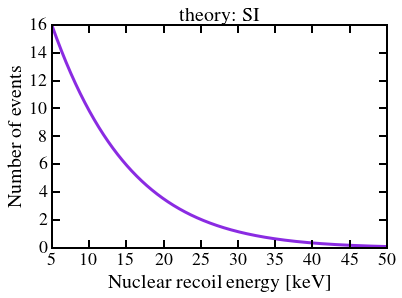

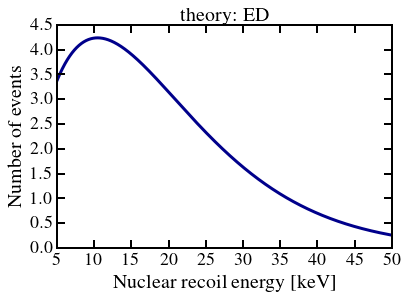

In [21]:
dmdd.dp.plot_spectrum('xenon',Qmin=5,Qmax=50,exposure=1000,
                      sigma_name='sigma_si',sigma_val=70,
                      fnfp_name='fnfp_si', fnfp_val=1,
                      mass=50, title='theory: SI',color='BlueViolet')
dmdd.dp.plot_spectrum('xenon',Qmin=5,Qmax=50,exposure=1000,
                      sigma_name='sigma_elecdip',sigma_val=70,
                      mass=50, title='theory: ED',color='DarkBlue')

NOTES: 

- Values of the cross-sections passed to the rate functions are normalized with normalizations stored in `PAR_NORMS` dictionary in globals module; the values used in all calculations are always of this form:  `sigma_si * dmdd.PAR_NORMS['sigma_si']`

- `v_rms` variable is equal to 3/2 * (Maxwellian rms velocity of ~155km/sec) ~ 220 km/sec
- `v_esc` is in the Galactic frame

II. `Experiment` Object
------------


This object packages all the information that defines a single "experiment". For statistical analysis, a list of these objects is passed to initialize an instance of a `MultinestRun` object, or to initialize an instance of a `Simulation` object.  It can also be used on its own to explore the capabilities of a theoretical experiment. Experiments set up here can either have perfect energy resolution in a given analysis window, or no resolution (controlled by the parameter `energy_resolution`, default being `True`). 

This is how you can define and use an instance of `Experiment`:


In [45]:
# intialize and instances of Experiment object with a germanium target, with energy resolution, 
# and lower energy threshold of keV, upper threshold of 100 keV, and 200 kg-year exposure:
ge = dmdd.Experiment('Ge','germanium',1,100,200,dmdd.eff.efficiency_unit, energy_resolution=True)

# and a similar fluorine target with no energy resolution:
flu = dmdd.Experiment('F','fluorine',1,100,200,dmdd.eff.efficiency_unit, energy_resolution=False)

print 'experiment: {} ({:.0f} kg-yr)'.format(ge.name, ge.exposure)
minimum_mx = ge.find_min_mass(v_esc=540., v_lag=220., mx_guess=1.) 
# this is the minimum detectable WIMP mass, 
# given the recoil-energy threshold, and escape velocity 
# from the Galaxy in the lab frame = v_esc + v_lag.

print 'minimum detectable WIMP mass: {:.1f} GeV'.format(minimum_mx)

# this is how to get the projected reach for such experiment for mx=50GeV,
# for sigma_p under a given theory, in this case, the standard spin-dependent scattering,
# assuming the experiment has 4 expected background events:

sigma = ge.sigma_limit(sigma_name='sigma_sd', fnfp_name='fnfp_sd', fnfp_val=-1.1,
                                mass=50, Nbackground=4, sigma_guess = 1e10, mx_guess=1.,
                                v_esc=540., v_lag=220., v_rms=220., rho_x=0.3)

sigma_normalized = sigma * dmdd.PAR_NORMS['sigma_sd']

print 'projected exclusion for SD scattering @ 50 GeV: sigma_p = {:.2e} cm^2'.format(sigma_normalized)


experiment: Ge (200 kg-yr)
minimum detectable WIMP mass: 2.4 GeV
projected exclusion for SD scattering @ 50 GeV: sigma_p = 2.07e-41 cm^2


NOTE: initialization of this class requires passing of the efficiency function. Flat unit efficiency is available in `dmdd.dmdd_efficiency` module. You may want to include in there any new specific efficiency function you'd like to use.


III. `Model` Object
--------

This object facilitates handling of a "hypothesis" that describes the scattering interaction at hand (to be used either to simulate recoil spectra, or to fit to the simulated recoil events). You have an option to set any parameter to have a fixed value, which will not be varied if the model is used to fit data.

Here's how you can use a general `Model` object, or its sub-class `UV_Model`:

In [73]:
# more general way that uses a general Model class:

# set all sigma_p to zero by default:
default_rate_parameters = dict(mass=50., sigma_si=0., sigma_sd=0., sigma_anapole=0., sigma_magdip=0., sigma_elecdip=0.,
                                    sigma_LS=0., sigma_f1=0., sigma_f2=0., sigma_f3=0.,
                                    sigma_si_massless=0., sigma_sd_massless=0.,
                                    sigma_anapole_massless=0., sigma_magdip_massless=0.,  sigma_elecdip_massless=0.,
                                    sigma_LS_massless=0.,  sigma_f1_massless=0.,  sigma_f2_massless=0.,  sigma_f3_massless=0.,
                                    fnfp_si=1.,  fnfp_sd=1.,
                                    fnfp_anapole=1.,  fnfp_magdip=1.,  fnfp_elecdip=1.,
                                    fnfp_LS=1.,  fnfp_f1=1.,  fnfp_f2=1.,  fnfp_f3=1.,
                                    fnfp_si_massless=1.,  fnfp_sd_massless=1.,
                                    fnfp_anapole_massless=1.,  fnfp_magdip_massless=1.,  fnfp_elecdip_massless=1.,
                                    fnfp_LS_massless=1.,  fnfp_f1_massless=1.,  fnfp_f2_massless=1.,  fnfp_f3_massless=1.,
                                    v_lag=220.,  v_rms=220.,  v_esc=544.,  rho_x=0.3)
elecdip = dmdd.Model('Elec.dip.light', ['mass','sigma_elecdip'], 
                           dmdd.rate_UV.dRdQ, dmdd.rate_UV.loglikelihood,
                           default_rate_parameters)


# shortcut for scattering models corresponding to rates coded in rate_UV:
elecdip = dmdd.UV_Model('Elec.dip.', ['mass','sigma_elecdip'])

print 'model: {}, parameters: {}'.format(elecdip.name, elecdip.param_names)

# if you wish to set some of the parameters to be fixed
# when this model is used to fit data, you can define a dict fixed_params, e.g.:
millicharge = dmdd.UV_Model('Millicharge', ['mass', 'sigma_si_massless'], 
                           fixed_params={'fnfp_si_massless': 0})

print 'model: {}, parameters: {}; fixed: {}'.format(millicharge.name, 
                                         millicharge.param_names,
                                         millicharge.fixed_params)


model: Elec.dip., parameters: ['mass', 'sigma_elecdip']
model: Millicharge, parameters: ['mass', 'sigma_si_massless']; fixed: {'fnfp_si_massless': 0}


IV. `Simulation` Object
----

This object handles a single simulated data set (nuclear recoil energy spectrum). It is generaly initialized and used by the `MultinestRun` object, but can be used stand-alone. 

Simulation data will only be generated if a simulation with the right parameters and name does not already exist, or if `force_sim=True` is provided upon `Simulation` initialization; if the data exist, it will just be read in.  (Data is a list of nuclear recoil energies of "observed" events.) Initializing `Simulation` with given parameters for the first time will produce 3 files, located by default at `$DMDD_PATH/simulations` (or `./simulations` if `$DMDD_PATH` not defined): 

- .dat file with a list of nuclear-recoil energies (keV), drawn from a Poisson distribution with $<N>$ = number of events expected at a given energy for a given underlying scattering model and given experimental parameters. 
- .pkl file with all relevant initialization parameters for record
- .pdf plot of the simulated recoil-energy spectrum with simulated data points (with Poisson error bars) on top of the underlying model

Below is an example of `Simulation`.


In [ ]:
# intialize an Experiment with iodine target, to be passed to Simulation:
iod = dmdd.Experiment('I','iodine',5,80,1000,dmdd.eff.efficiency_unit, energy_resolution=True)

# initialize a simulation with iod, for elecdip model defined above,
# for 50 GeV WIMP, for sigma_si = 70*PAR_NORMS['sigma_elecdip'] = 7e-43 cm^2: 
test = dmdd.Simulation('simdemo', iod, elecdip, {'mass':50.,'sigma_elecdip':70.})

In [70]:
# you can easily access various attributes of this class, e.g.:
print 'simulation \'{}\' was done for experiment \'{}\', \
it had N={:.0f} events (<N>={:.0f} events), \n and \
the parameters passed to dRdQ were:\n\n {}'.format(test.name, 
                                                   test.experiment.name,
                                                   test.N,
                                                   test.model_N,
                                                   test.dRdQ_params)

print '\n List of energies generated in {} is: \n\n'.format(test.name),test.Q


simulation 'simdemo' was done for experiment 'I', it had N=102 events (<N>=100 events), 
 and the parameters passed to dRdQ were:

 {'fnfp_magdip_massless': 1.0, 'sigma_f3_massless': 0.0, 'sigma_f1': 0.0, 'fnfp_sd_massless': 1.0, 'v_rms': 220.0, 'sigma_f2': 0.0, 'fnfp_f1': 1.0, 'fnfp_f2': 1.0, 'fnfp_f2_massless': 1.0, 'sigma_magdip': 0.0, 'sigma_f1_massless': 0.0, 'fnfp_elecdip': 1.0, 'sigma_f2_massless': 0.0, 'sigma_si': 0.0, 'sigma_sd_massless': 0.0, 'sigma_si_massless': 0.0, 'v_lag': 220.0, 'fnfp_LS': 1.0, 'sigma_anapole_massless': 0.0, 'sigma_anapole': 0.0, 'fnfp_f3_massless': 1.0, 'sigma_magdip_massless': 0.0, 'sigma_sd': 0.0, 'fnfp_LS_massless': 1.0, 'fnfp_anapole_massless': 1.0, 'sigma_f3': 0.0, 'rho_x': 0.3, 'fnfp_magdip': 1.0, 'sigma_elecdip_massless': 0.0, 'fnfp_si_massless': 1.0, 'sigma_elecdip': 70.0, 'v_esc': 544.0, 'sigma_LS': 0.0, 'fnfp_f1_massless': 1.0, 'element': 'iodine', 'fnfp_si': 1.0, 'mass': 50.0, 'fnfp_anapole': 1.0, 'sigma_LS_massless': 0.0, 'fnfp_f3': 1.0, 'fn

V. `MultinestRun` Object
----

This is a "master" class of `dmdd` that makes use of all other objects. It takes in experimental parameters, particle-physics parameters, and astrophysical parameters, and then generates a simulation (if it doesn't already exist), and prepares to perform `MultiNest` analysis of simulated data.  It has methods to do a `MultiNest` run (`.fit()` method) and to visualize outputs (`.visualize()` method). `Model` used for simulation does not have to be the same as the `Model` used for fitting. Simulated spectra from multiple experiments will be analyzed jointly if `MultiNest` run is initialized with a list of appropriate `Experiment` objects.

The likelihod function is an argument of the fitting model (`Model` object); for UV models it is set to `dmdd.rate_UV.loglikelihood`, and for models that would correspond to `rate_genNR`, `dmdd.rate_genNR.loglikelihood`. Both likelihood functions include the Poisson factor, and, if `energy_resolution=True` of the `Experiment` at hand, the factors that evaluate probability of each individual event, given the fitting model. 

Example usage of `MultinestRun` is given below:

In [4]:
# simulate and analyze data from germanium and xenon targets:
xe = dmdd.Experiment('Xe', 'xenon', 5, 40, 1000, dmdd.eff.efficiency_unit)
ge = dmdd.Experiment('Ge', 'germanium', 0.4, 100, 100, dmdd.eff.efficiency_unit)

# simulate data for anapole interaction:
simmodel = dmdd.UV_Model('Anapole', ['mass','sigma_anapole'])

# fit data with standard SI interaction
fitmodel = dmdd.UV_Model('SI', ['mass', 'sigma_si'], fixed_params={'fnfp_si': 1.})


# initialize run:
run = dmdd.MultinestRun('simdemo1', [xe,ge], simmodel,{'mass':50.,'sigma_anapole':45.},
                   fitmodel, prior_ranges={'mass':(1,1000), 'sigma_si':(0.001,10000)})

simulation had 172 events (expected 168).
simulation had 14 events (expected 15).



 Fit took 0.000026480357 minutes.



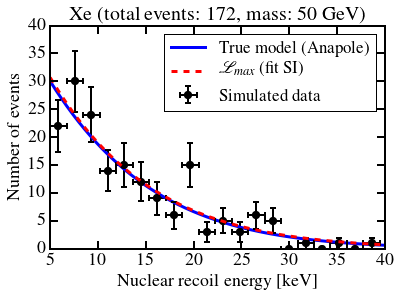

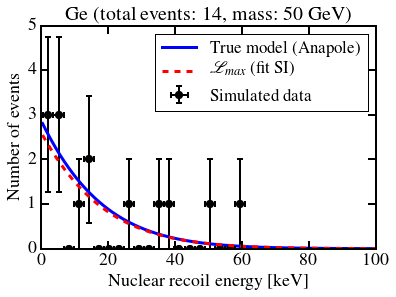

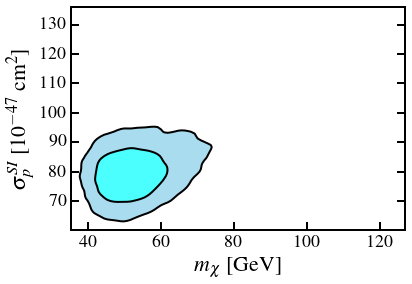

In [3]:
# now run MultiNest and visualize data:
run.fit()
run.visualize()
 

The `.visualize()` method produces 2 types of plots (shown above):

- recoil spectra for each experiment used in the analysis, where data points, theory model, and best-fit model are all shown.
- 2d (marginalized) posteriors for every pair or fitting parameters, showing typically mass vs. cross-section $\sigma_p$.

Simulations are saved in `$DMDD_PATH/simulations` directory directly, and `MultiNest` chains and plots produced by the `.visualize()` method are saved in the appropriate chains file, in this case the following directory:


In [5]:
print run.chainspath

/Users/verag/Research/dmdd/dmdd_data_2014//chains_uv//simdemo1_Ge_Xe_mass_50.00_sigma_anapole_45.00_fitfor_mass_sigma_si_fixed_fnfp_si_1.00_logflat_nlive2000/


OTHER NOTES:
---------

- Non-relativistic operators that correspond to `rate_genNR` have not yet been tested with the `MultinestRun` class, and so `rate_NR` and `rate_genNR` for now should only be used for rate calculations.
- While all four astrophysical parameters can be free parameters in a `MultinestRun`, all rate calculators only assume a strictly Maxwellian velocity distribution.
- In the current implementation, the `Experiment` object can only handle a single-element target.




 
